In [2]:
import numpy as np
import os
import sys
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ImageDraw as ImageDraw
%matplotlib inline
import csv

sys.path.append("path/to/models/research/object_detection/")
sys.path.append("/path/to/models/research/")
sys.path.append("classifier")

from neiro_network import pre_process_image, model_classify
from utils import label_map_util
from utils import visualization_utils as vis_util

if tf.__version__ != '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.0!')


PATH_TO_LABELS = os.path.join('data/sign_label.pbtxt')
curr_path = os.getcwd()
PATH_TO_CKPT = os.path.join(curr_path, 'model/frozen_inference_graph.pb')

NUM_CLASSES = 1
IMAGE_SIZE = (12, 8)

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [5]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [6]:
PATH_TO_TEST_IMAGES_DIR = '../TestIJCNN2013/'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, img) 
                        for img in os.listdir(PATH_TO_TEST_IMAGES_DIR) if '.ppm' in img]

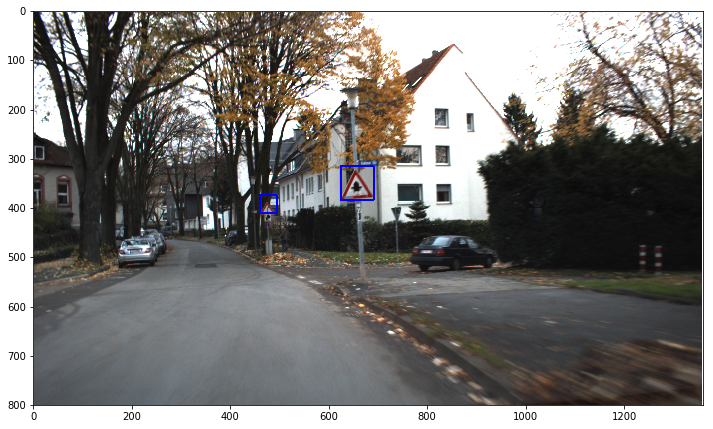

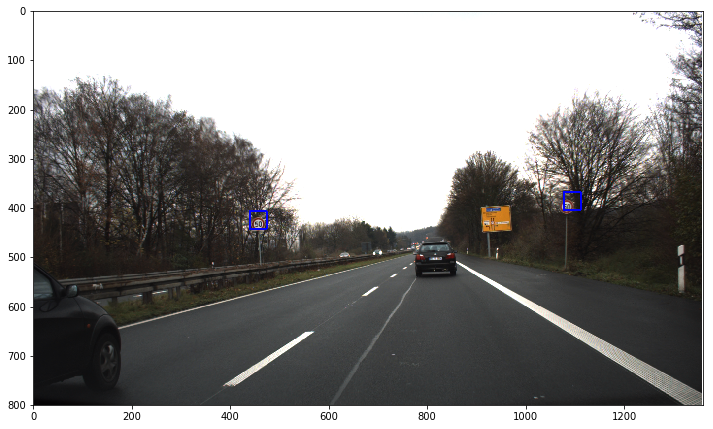

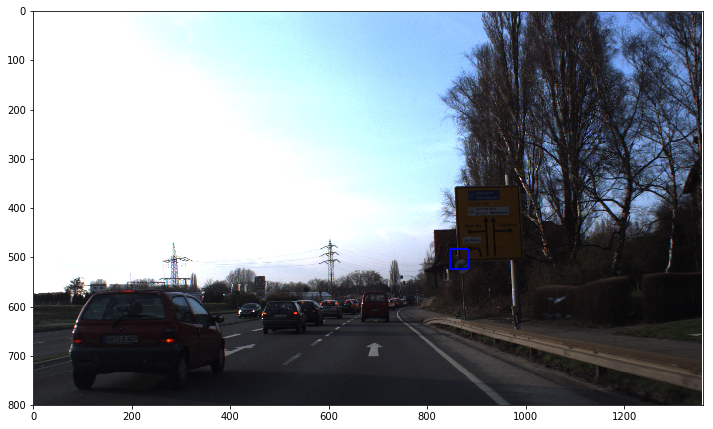

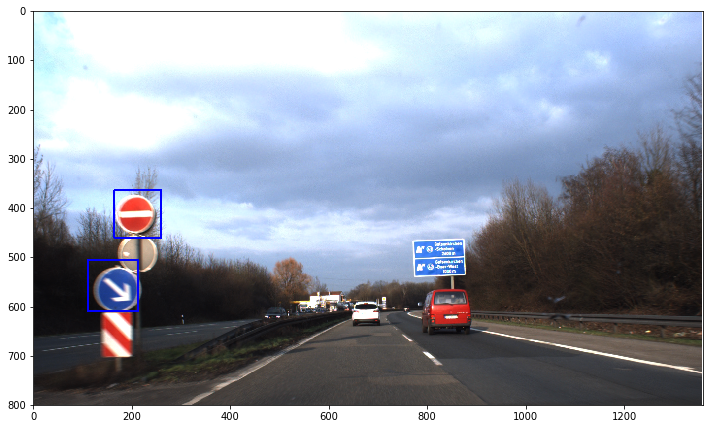

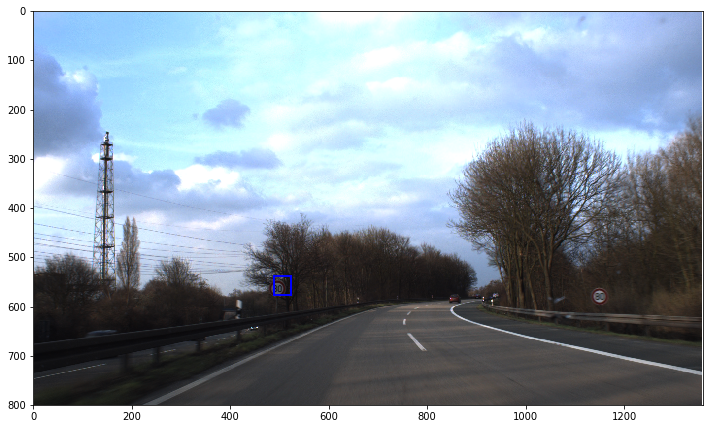

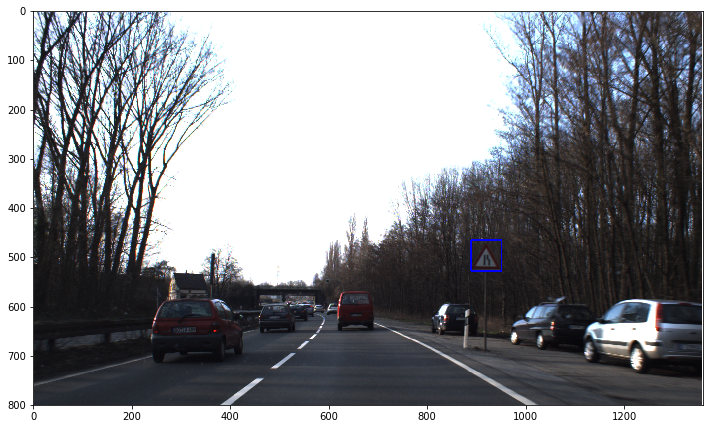

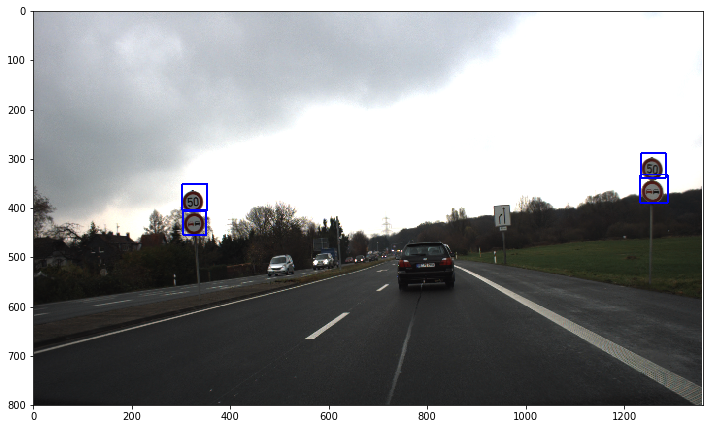

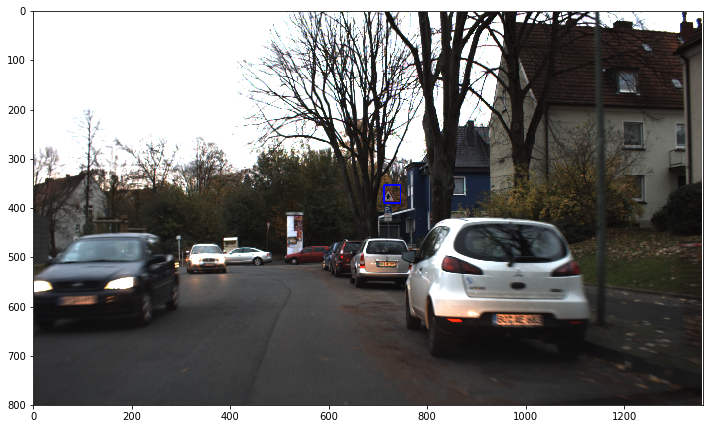

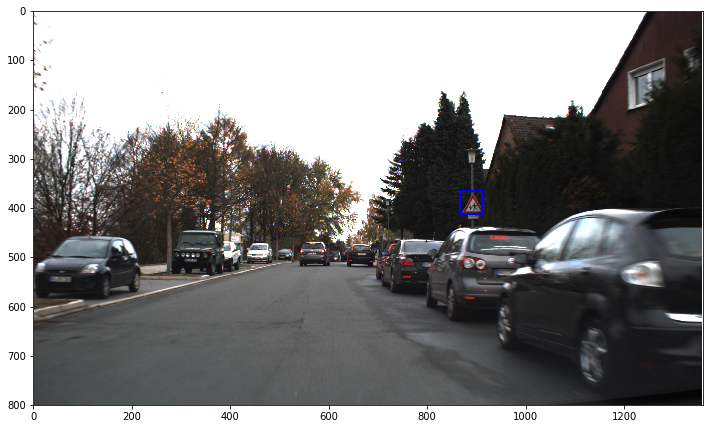

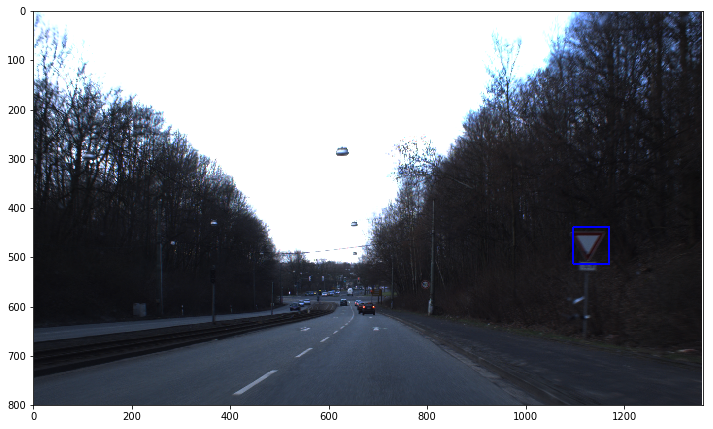

In [8]:
sub_imgs = dict()

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            img = cv2.imread(image_path)
            image_np_expanded = np.expand_dims(image_np, axis=0)

            (boxes, scores) = sess.run(
              [detection_boxes, detection_scores],
              feed_dict={image_tensor: image_np_expanded})
            
            image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
            draw = ImageDraw.Draw(image_pil)
            w,h,_ = image_np.shape
            
            scores = scores[0]    
            boxes = boxes[0][scores > 0.7]
            boxes[:,::2] = boxes[:,::2]*w
            boxes[:,1::2] = boxes[:,1::2]*h
            
            im_width, im_height = image_pil.size            
            el_sub_img = np.empty((boxes.shape[0], 48, 48, 3))
            koord_box = []
            
            for ind, box in enumerate(boxes):
                
                ymin, xmin, ymax, xmax = map(int, box)

                side = int( max(xmax - xmin, ymax - ymin)*1.1/2)
                xmean = (xmin+xmax)//2
                ymean = (ymin+ymax)//2                
                
                left, right, top, bottom = (max(xmean - side, 0), min(xmean + side, im_width), 
                                            max(ymean - side, 0), min(ymean + side, im_height))
                
                koord_box.append([top, left, bottom, right])
                el_sub_img[ind] = pre_process_image(
                        cv2.resize(img[top:bottom, left:right,:], (48,48)))
                
                
                draw.line([(left, top), (left, bottom), (right, bottom),
                (right, top), (left, top)], width=4, fill='blue')

            name = image_path.split('/')[-1]
            sub_imgs[name] = [koord_box, el_sub_img]
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_pil)

In [9]:
model = model_classify()
model.load_weights("model/weights_sign.hdf5")

In [11]:
with open('result.csv', "w", newline="") as file:
    writer = csv.writer(file)

    for name, item in sub_imgs.items():
        box,img = item
        writer.writerow([name, len(box)])
        
        y_pred = model.predict(img)
        args = np.argmax(np.array(y_pred), axis=1) if len(y_pred) else []
        for arg,el in zip(args, box):
            writer.writerow([arg, *el])